In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle


In [2]:
dataset = 'SMD'
data_path = "../ServerMachineDataset/processed"
x_dim = 38

file = 2, 1

In [3]:
f = open(f'{data_path}/machine-{file[0]}-{file[1]}_train.pkl', "rb")
data = pickle.load(f).reshape((-1, x_dim))
f.close()
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.202020,0.017243,0.025250,0.045836,0.473684,0.796716,0.494849,0.0,0.000536,0.006692,...,0.0,0.020833,0.318423,0.282051,0.0,0.020305,0.224057,0.230425,0.0,0.0
1,0.101010,0.011126,0.022749,0.044159,0.473684,0.807533,0.513385,0.0,0.000000,0.000035,...,0.0,0.020833,0.261941,0.230769,0.0,0.030457,0.141509,0.147651,0.0,0.0
2,0.131313,0.013384,0.023072,0.044718,0.473684,0.824876,0.532083,0.0,0.000268,0.000000,...,0.0,0.020833,0.269901,0.256410,0.0,0.035533,0.146226,0.154362,0.0,0.0
3,0.080808,0.008252,0.020248,0.042854,0.473684,0.683662,0.379113,0.0,0.000000,0.000000,...,0.0,0.020833,0.240902,0.205128,0.0,0.005076,0.129717,0.131991,0.0,0.0
4,0.090909,0.008088,0.017264,0.040060,0.473684,0.655085,0.348048,0.0,0.000000,0.000000,...,0.0,0.020833,0.261562,0.282051,0.0,0.055838,0.146226,0.154362,0.0,0.0


<Figure size 432x288 with 0 Axes>

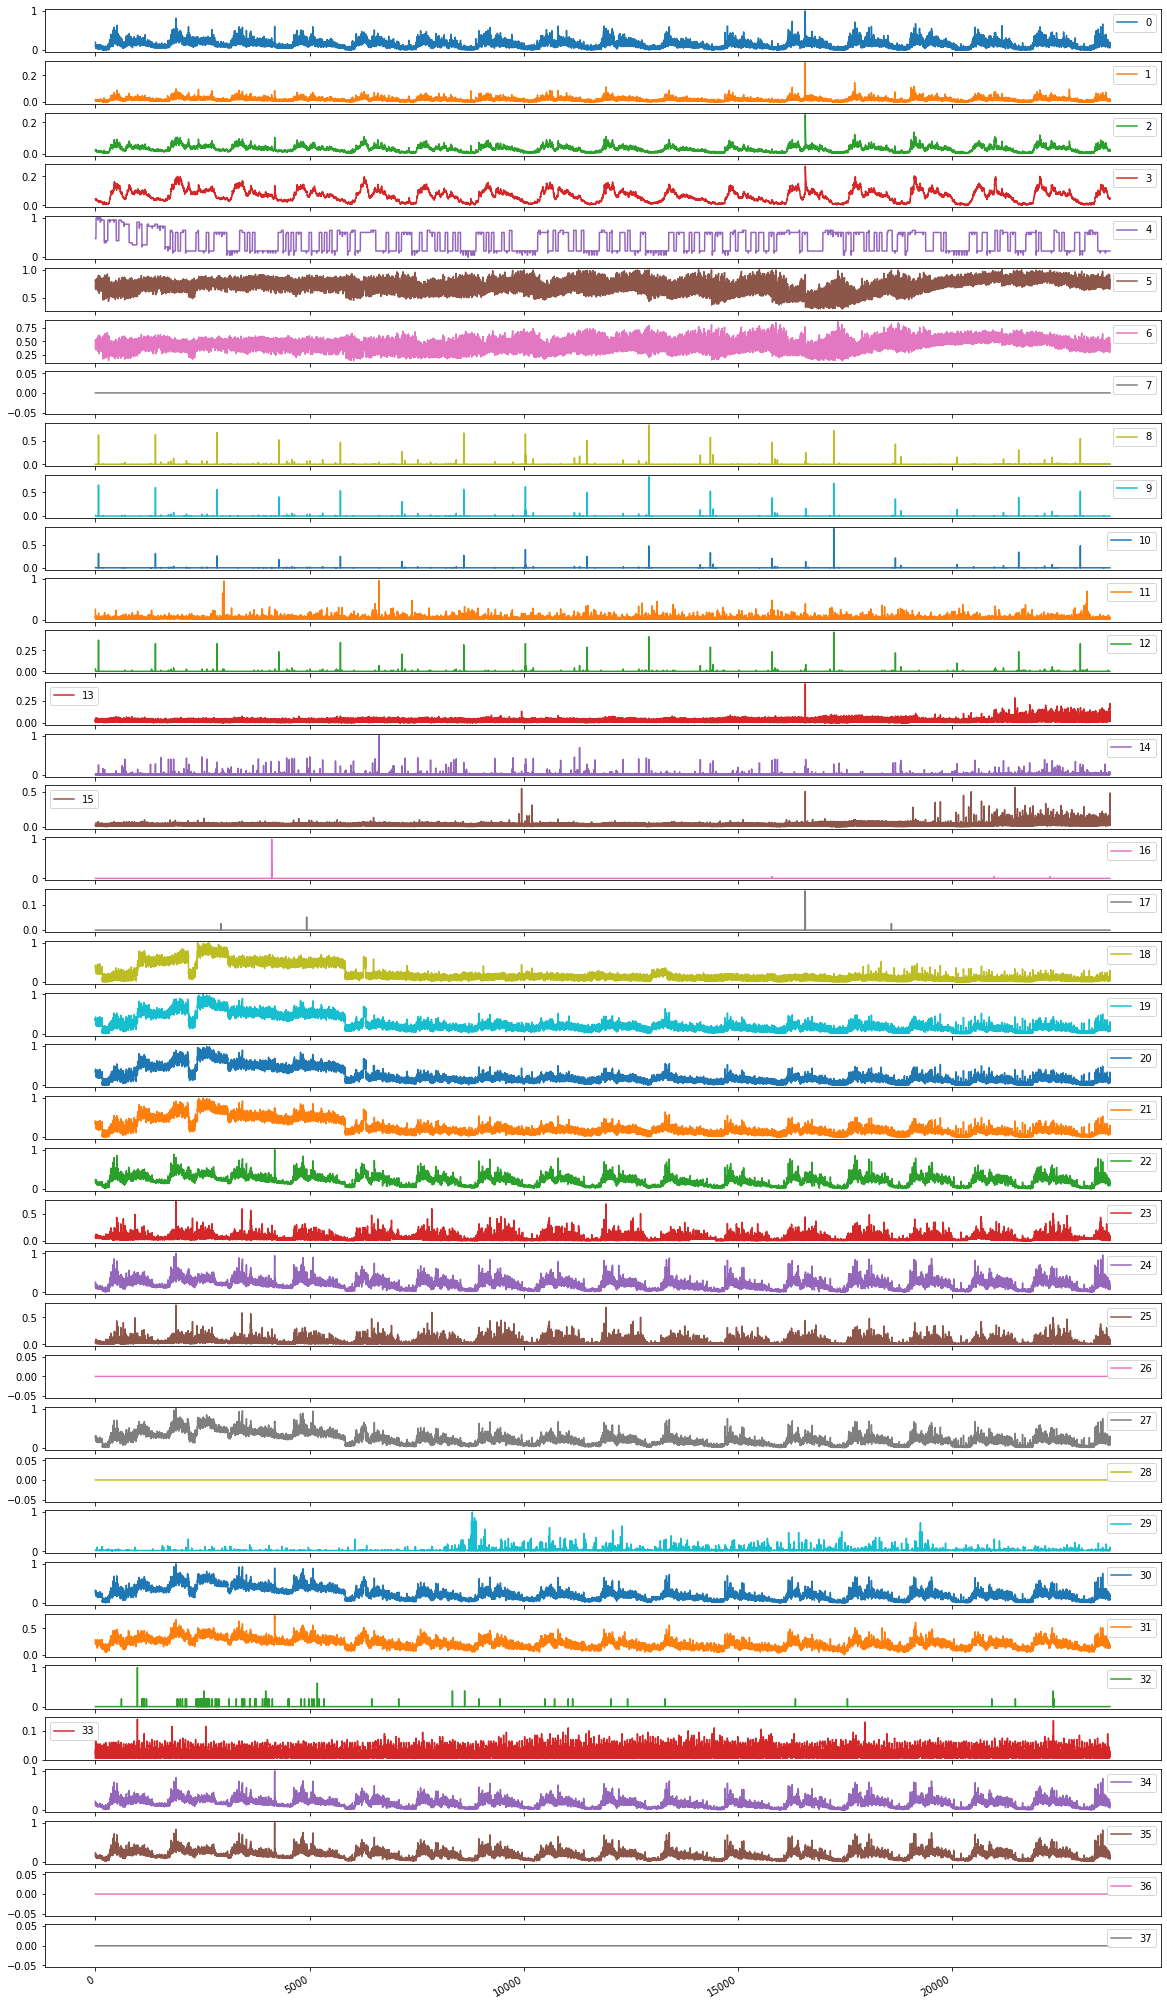

In [4]:
plt.tight_layout()
df.plot(subplots=True, figsize=(20,40))
plt.show();

In [5]:
f = open(f'{data_path}/machine-{file[0]}-{file[1]}_test.pkl', "rb")
data = pickle.load(f).reshape((-1, x_dim))
f.close()
df_test = pd.DataFrame(data)

f = open(f'{data_path}/machine-{file[0]}-{file[1]}_test_label.pkl', "rb")
test_labels = pickle.load(f)
f.close()
df_test['Anomaly'] = test_labels

<Figure size 432x288 with 0 Axes>

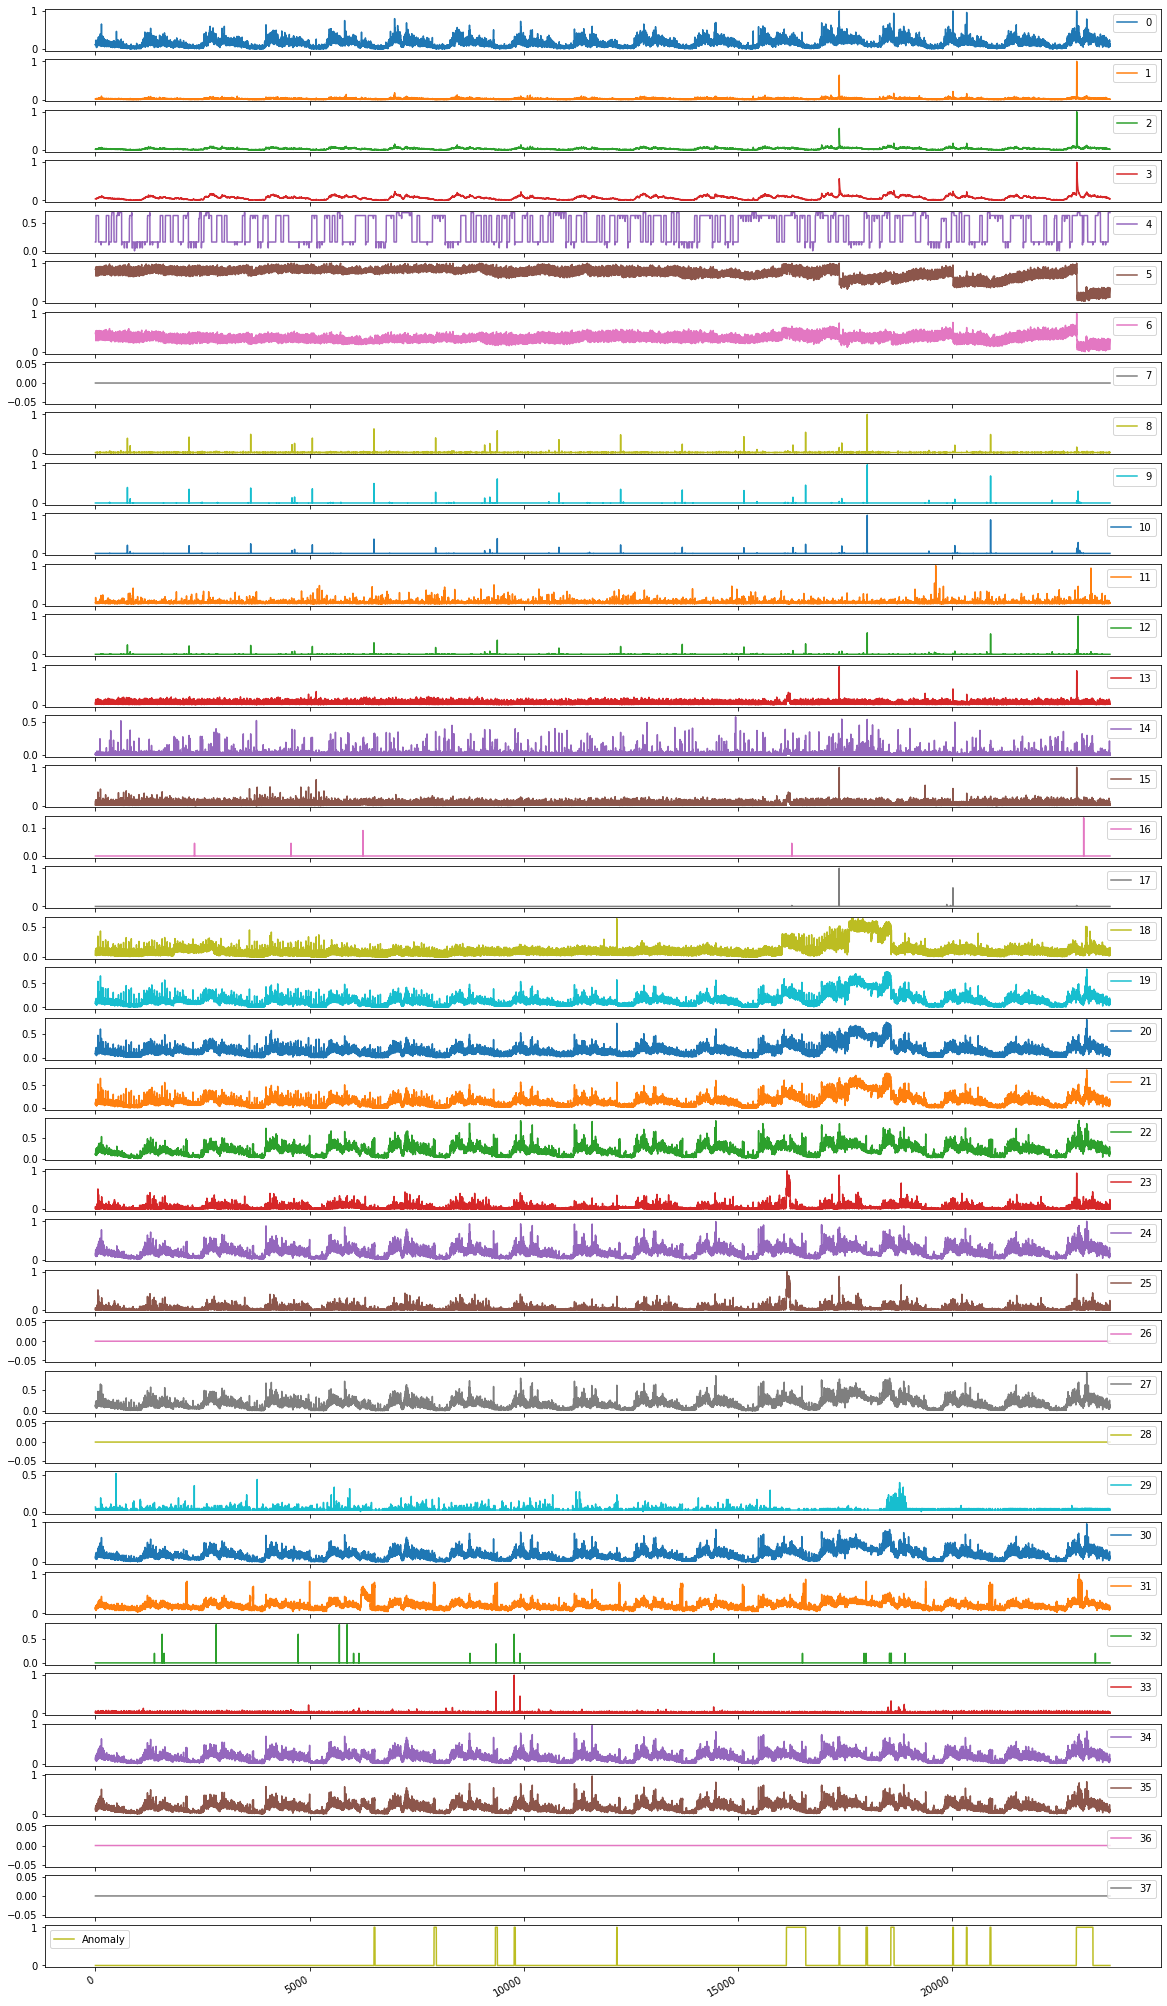

In [6]:
plt.tight_layout()
df_test.plot(subplots=True, figsize=(20,40))
plt.show();

In [7]:
df.shape[0] + df_test.shape[0]

47387

In [8]:
df_comb = pd.concat([df, df_test], ignore_index=True)
df_comb.shape

(47387, 39)

<Figure size 432x288 with 0 Axes>

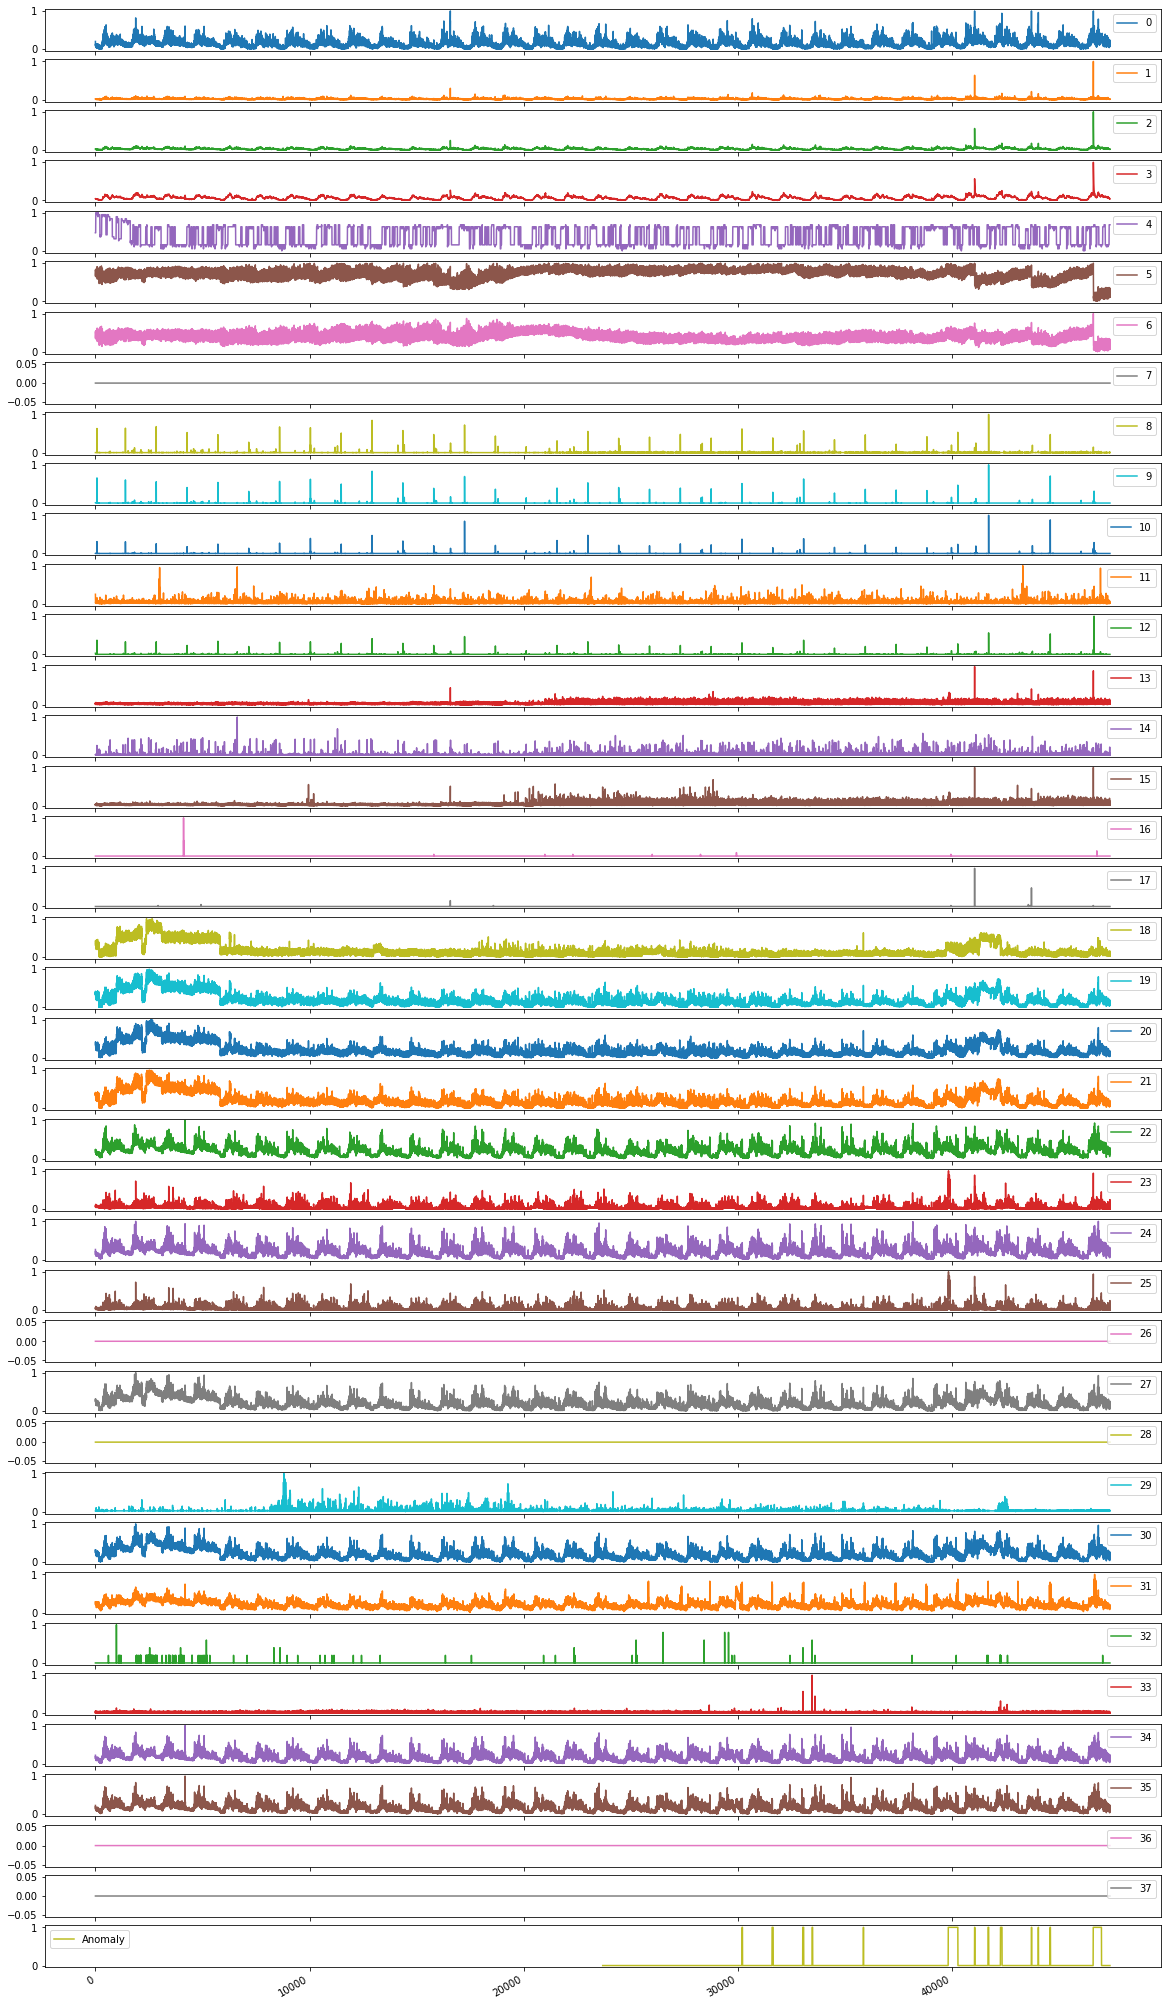

In [9]:
plt.tight_layout()
df_comb.plot(subplots=True, figsize=(20,40))
plt.show();

In [78]:
from alibi_detect.od import SpectralResidual
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_ts
from scipy import interpolate

od = SpectralResidual(
    threshold=None,
    window_amp=500,
    window_local=500,
    n_est_points=10,
    n_grad_points=5
)

No threshold level set. Need to infer threshold using `infer_threshold`.


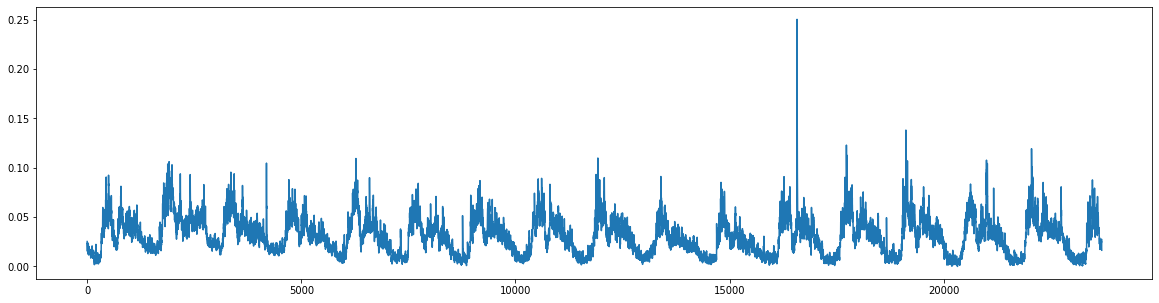

In [79]:
x = df.iloc[:,2].values
plt.figure(figsize=(20, 5))
plt.plot(x)

In [80]:
od.infer_threshold(x, threshold_perc=99.9)
od.threshold

4.166644035446716

In [81]:
preds = od.predict(
    x,
    #t=t,  # array with timesteps, assumes dt=1 between observations if omitted
    return_instance_score=True
)

In [82]:
preds

{'data': {'instance_score': array([ 6.96504892,  1.79670882,  3.63287959, ..., -0.42278145,
          0.37681006, -0.77091269]),
  'feature_score': None,
  'is_outlier': array([1, 0, 0, ..., 0, 0, 0])},
 'meta': {'name': 'SpectralResidual',
  'detector_type': 'online',
  'data_type': 'time-series'}}

In [83]:
a_scores = preds['data']['instance_score']
is_a = preds['data']['is_outlier']

print(is_a.shape)
print(x.shape)

(23693,)
(23693,)


In [84]:
x_interp = x.copy()
x_interp[np.where(is_a == 1)] = np.NaN
x_interp = pd.Series(x_interp)
print(pd.isna(x_interp).sum())
x_interp = x_interp.interpolate(method='pad')
print(pd.isna(x_interp).sum())

24
1


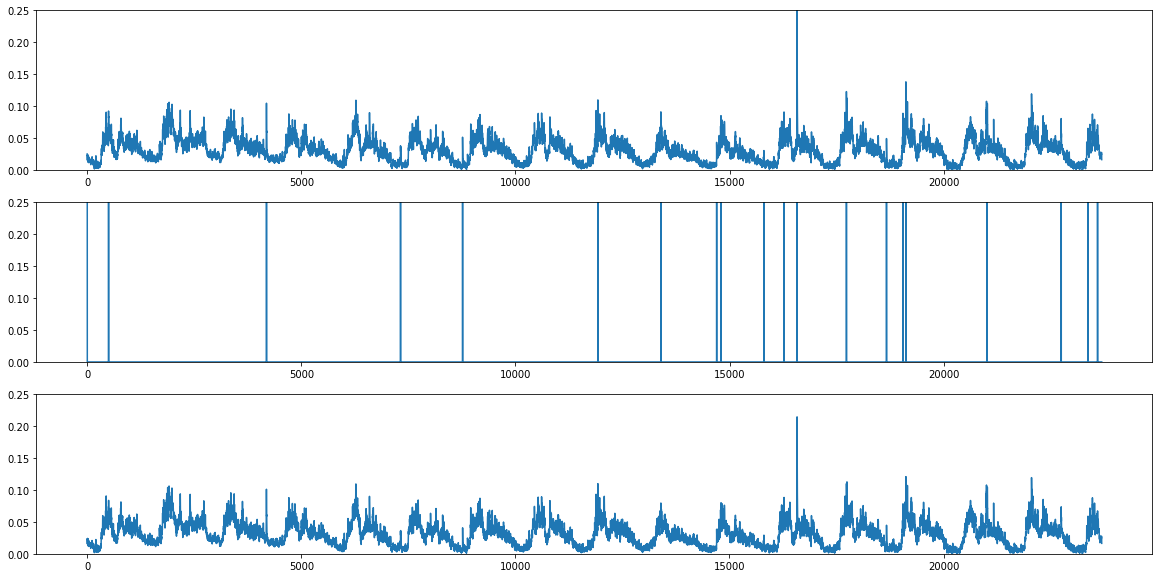

In [85]:

fig, axs = plt.subplots(3, figsize=(20,10))
axs[0].set_ylim([0, max(x)])
axs[1].set_ylim([0, max(x)])
axs[2].set_ylim([0, max(x)])

axs[0].plot(x)
axs[1].plot(is_a)
axs[2].plot(x_interp)


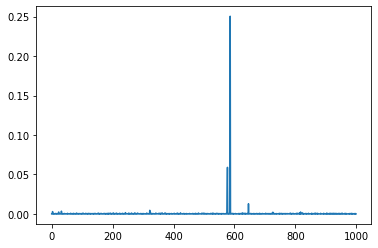

In [60]:
plt.plot(x[16000:17000])

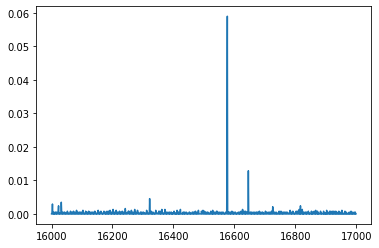

In [61]:
plt.plot(x_interp[16000:17000])

In [96]:
a = np.ones((10000, 38))
b = np.ones((10000, 38))
c = np.sqrt((a-b)**2)
print(c.shape)

d = np.mean(c, 1)
d.shape

(10000, 38)


(10000,)

In [94]:
np.sqrt(d).shape

(10000,)

In [97]:
output = pd.read_csv('../plots/smd/output.csv')

In [98]:
output.head()

,Unnamed: 0,Pred_0,True_0,RSE_0,Pred_1,True_1,RSE_1,Pred_2,True_2,RSE_2,...,True_35,RSE_35,Pred_36,True_36,RSE_36,Pred_37,True_37,RSE_37,Pred_Anomaly,True_Anomaly
0,0,0.115562,0.252525,0.136963,0.014825,0.021266,0.006441,0.031432,0.038238,0.006806,...,0.255034,0.153435,0.024054,0.0,0.024054,-0.008999,0.0,0.008999,-1,NaN
1,1,0.115717,0.242424,0.126707,0.014905,0.022826,0.007921,0.031438,0.037431,0.005993,...,0.230425,0.128653,0.024027,0.0,0.024027,-0.008944,0.0,0.008944,-1,NaN
2,2,0.115836,0.222222,0.106386,0.014963,0.028410,0.013447,0.031441,0.040658,0.009217,...,0.241611,0.139705,0.024006,0.0,0.024006,-0.008905,0.0,0.008905,-1,NaN
3,3,0.115988,0.282828,0.166840,0.015039,0.022826,0.007787,0.031447,0.039287,0.007840,...,0.313199,0.211129,0.023977,0.0,0.023977,-0.008859,0.0,0.008859,-1,NaN
4,4,0.116182,0.141414,0.025232,0.015138,0.017571,0.002433,0.031459,0.037109,0.005650,...,0.255034,0.152748,0.023943,0.0,0.023943,-0.008793,0.0,0.008793,-1,NaN


<Figure size 432x288 with 0 Axes>

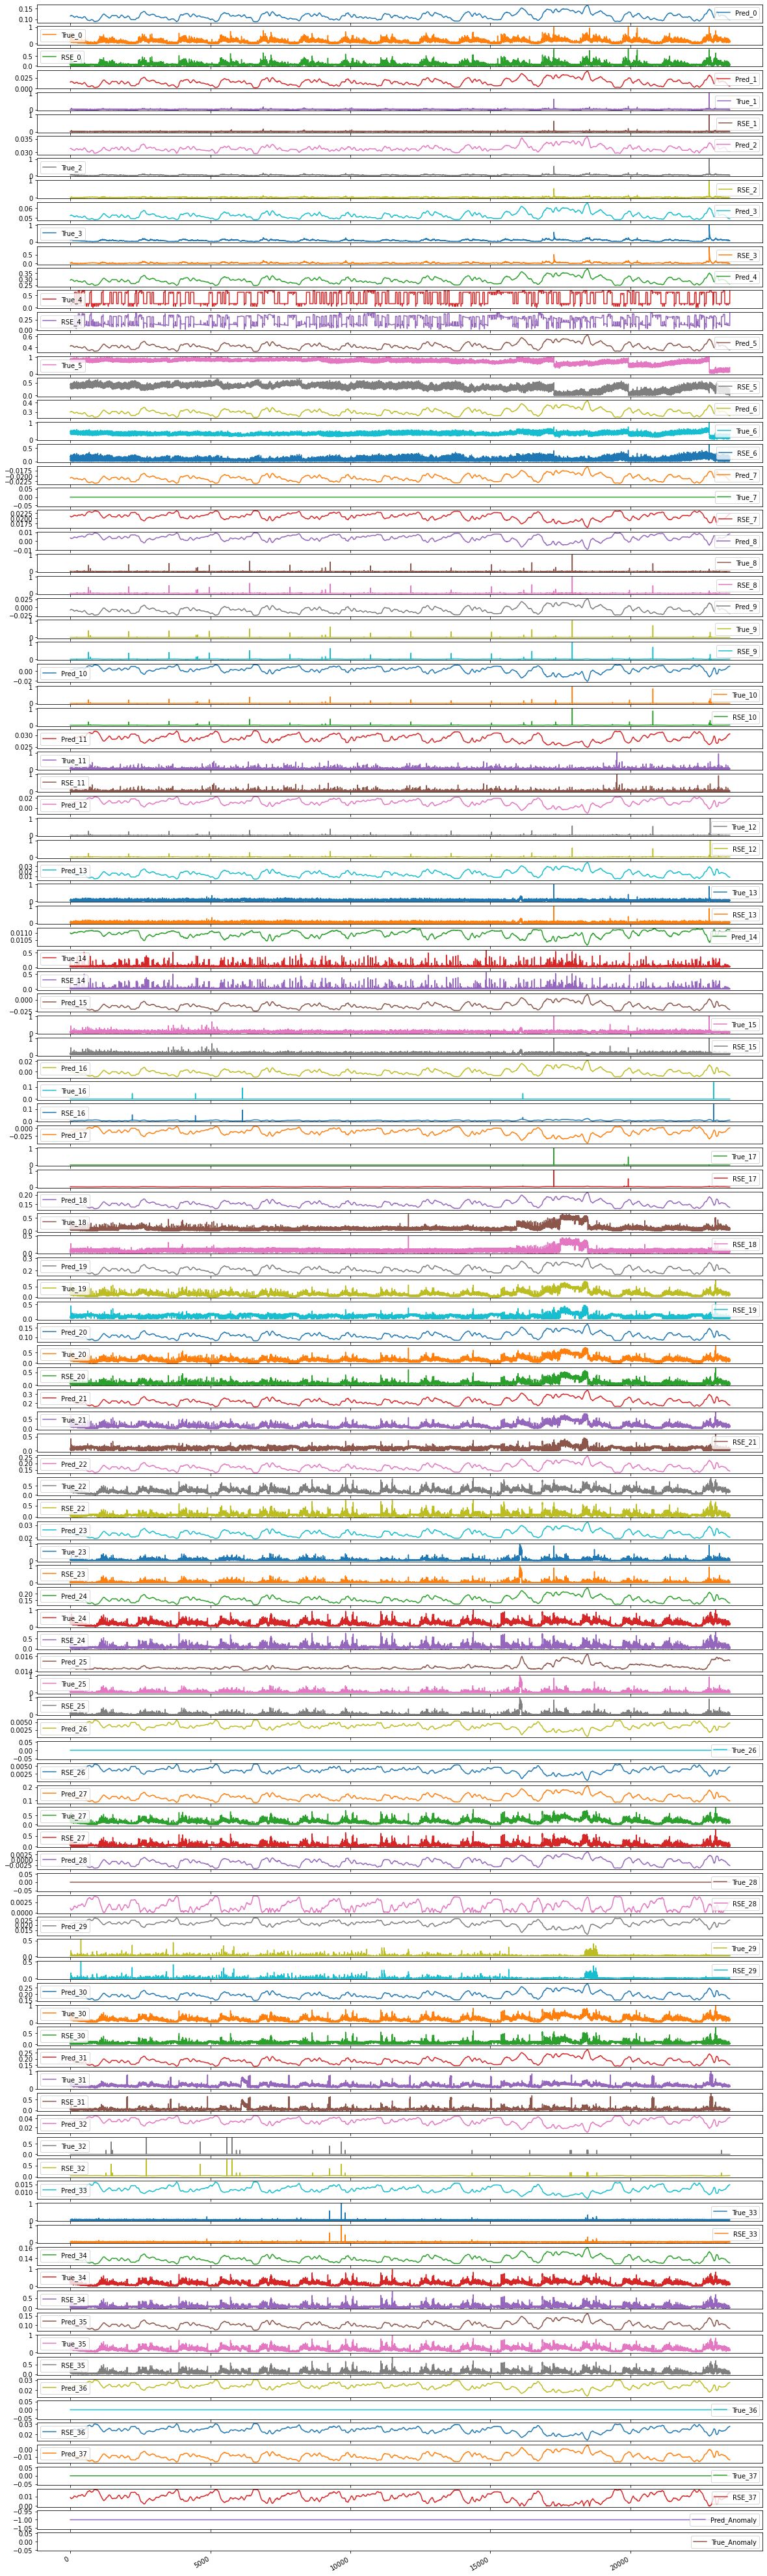

In [102]:
plt.tight_layout()
output.iloc[:, 1:].plot(subplots=True, figsize=(20,80))
plt.show();